## Chapter 23 - Ordinal Predicted Variable

- [23.2 - The Case of a Single Group](#23.2---The-Case-of-a-Single-Group)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import mode, norm
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

### 23.2 - The Case of a Single Group
Code based on https://gist.github.com/DanielWeitzenfeld/d9ac64f76281e6c1d29217af76449664

#### Data

In [2]:
# Using dtype 'category' for Y
df = pd.read_csv('data/OrdinalProbitData-1grp-1.csv', dtype={'Y':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
Y    100 non-null category
dtypes: category(1)
memory usage: 236.0 bytes


In [3]:
df.Y.value_counts()

1    58
2    15
3    12
4     8
5     4
6     2
7     1
Name: Y, dtype: int64

In [4]:
# Number of outcomes
nYlevels = df.Y.cat.categories.size

thresh = [k + .5 for k in range(1, nYlevels)]
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('tresh:\t\t{}'.format(thresh))
print('tresh_obs:\t{}'.format(thresh_obs))

tresh:		[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
tresh_obs:	[1.5 -- -- -- -- 6.5]


In [14]:
# Using the Theano @as_op decorator with a custom function to calculate the threshold probabilities.
# Theano cannot compute a gradient for these custom functions, so it is not possible to use
# gradient based samplers in PyMC3.
# http://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Arbitrary-deterministics
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty(nYlevels)
    n = norm(loc=mu, scale=sigma)       
    out[0] = n.cdf(theta[0])        
    out[1] = np.max([0, n.cdf(theta[1]) - n.cdf(theta[0])])
    out[2] = np.max([0, n.cdf(theta[2]) - n.cdf(theta[1])])
    out[3] = np.max([0, n.cdf(theta[3]) - n.cdf(theta[2])])
    out[4] = np.max([0, n.cdf(theta[4]) - n.cdf(theta[3])])
    out[5] = np.max([0, n.cdf(theta[5]) - n.cdf(theta[4])])
    out[6] = 1 - n.cdf(theta[5])
    return out

with pm.Model() as ordinal_model_single:    
    
    theta = pm.Normal('theta', mu=thresh, tau=np.repeat(.5**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs, testval=thresh[1:-1])
    
    mu = pm.Normal('mu', mu=nYlevels/2.0, tau=1.0/(nYlevels**2))
    sigma = pm.Uniform('sigma', nYlevels/1000.0, nYlevels*10.0)
    
    pr = outcome_probabilities(theta, mu, sigma)
    
    y = pm.Categorical('y', pr, observed=df.Y.cat.codes.as_matrix())

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [15]:
with ordinal_model_single:
    step = pm.Metropolis([theta, mu, sigma, pr, y])
    trace1 = pm.sample(10000, step=step)

 [-----------------100%-----------------] 10000 of 10000 complete in 131.8 sec

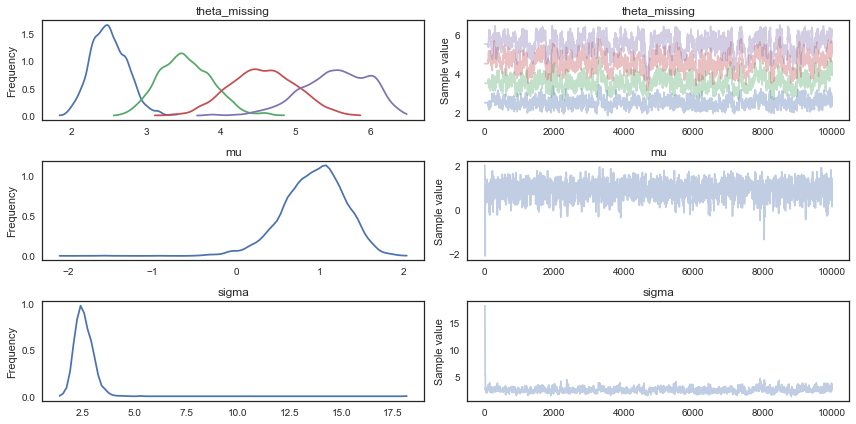

In [16]:
pm.traceplot(trace1);

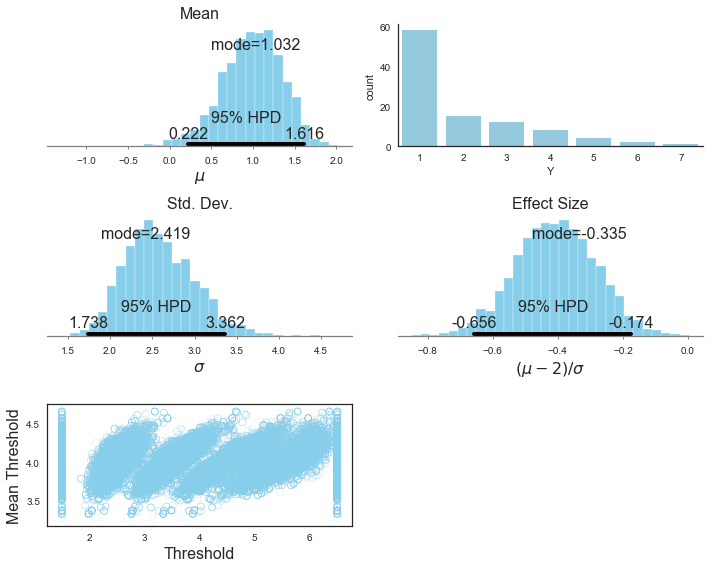

In [19]:
burnin=100
# trace length 
n = trace1['theta_missing'].shape[0]
# Concatenate the fixed thresholds into the estimated thresholds
thresholds = np.c_[np.tile([1.5], (n,1)),
                   trace1['theta_missing'],
                   np.tile([6.5], (n,1))][burnin:]

fig = plt.figure(figsize=(10,8))
# Define gridspec
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2,0])

pm.plot_posterior(trace1['mu'][burnin:], point_estimate='mode', color=color, ax=ax1)
ax1.set_title('Mean', fontdict=f_dict)
ax1.set_xlabel('$\mu$', fontdict=f_dict)

sns.countplot(df.Y, ax=ax2, color=color)
sns.despine(ax=ax2)

pm.plot_posterior(trace1['sigma'][burnin:], point_estimate='mode', color=color, ax=ax3)
ax3.set_title('Std. Dev.', fontdict=f_dict)
ax3.set_xlabel('$\sigma$', fontdict=f_dict)

pm.plot_posterior((trace1['mu'][burnin:]-2)/trace1['sigma'][burnin:],point_estimate='mode',  color=color, ax=ax4)
ax4.set_title('Effect Size', fontdict=f_dict)
ax4.set_xlabel('$(\mu-2)/\sigma$', fontdict=f_dict)

ax5.scatter(thresholds, np.tile(thresholds.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
ax5.set_xlabel('Threshold', fontdict=f_dict)

fig.tight_layout()